In [1]:
cd C:\Users\zsassi\test

c:\Users\zsassi\test


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
train_df = pd.read_csv("train.csv")
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
test_df = pd.read_csv('test.csv')
test_df.head()
test_df.info()
test_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

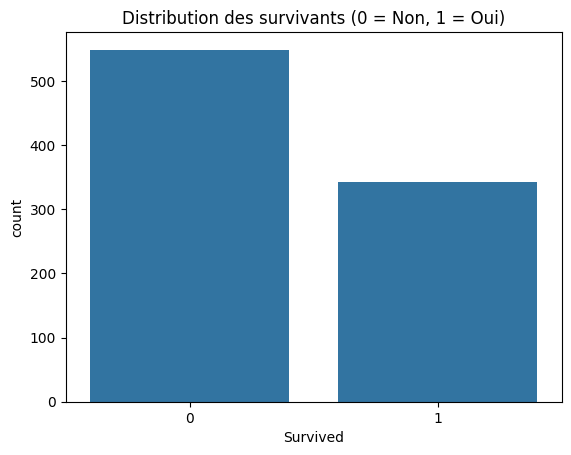

In [7]:
sns.countplot(data=train_df, x='Survived')
plt.title("Distribution des survivants (0 = Non, 1 = Oui)")
plt.show()

In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
embarked_dummies = pd.get_dummies(train_df['Embarked'], prefix='Embarked')
train_df = pd.concat([train_df, embarked_dummies], axis=1)
train_df.drop(columns=['Embarked'], inplace=True)
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
C:\Users\zsassi\AppData\Local\Temp\ipykernel_17860\831791945.py:7: SyntaxWarning: invalid escape sequence '\.'
  train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
C:\Users\zsassi\AppData\Local\Temp\ipykernel_17860\831791945.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
C:\Users\zsassi\AppData\Local\Temp\ipykernel_17860\831791945.p

In [10]:
# Simplifier les titres rares
train_df['Title'] = train_df['Title'].replace(['Lady', 'Countess','Capt','Col',\
         'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
train_df['Title'] = train_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs')

# Encoder les titres
title_mapping = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}
train_df['Title'] = train_df['Title'].map(title_mapping)
train_df['Title'].fillna(0, inplace=True)

# Supprimer les colonnes inutiles
train_df.drop(columns=['Name', 'Ticket'], inplace=True)
train_df['AgeGroup'] = pd.cut(train_df['Age'], bins=[0, 12, 18, 35, 60, 100], labels=[0,1,2,3,4])
train_df['AgeGroup'] = train_df['AgeGroup'].astype(int)
train_df.drop(columns=['Cabin'], inplace=True)


C:\Users\zsassi\AppData\Local\Temp\ipykernel_17860\1081984776.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Title'].fillna(0, inplace=True)


In [11]:
X = train_df.drop('Survived', axis=1)
y = train_df['Survived']

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
from sklearn.model_selection import train_test_split


In [18]:
for name, model in models.items():
    model.fit(X_train, y_train)               # Apprentissage
    y_pred = model.predict(X_test)            # Prédiction ici
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.7877
Random Forest Accuracy: 0.8436


c:\Users\zsassi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.8045


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [25]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"--- {name} ---")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print("Confusion Matrix :")
    print(cm)
    


--- Logistic Regression ---
Accuracy  : 0.7877
Precision : 0.7432
Recall    : 0.7432
Confusion Matrix :
[[86 19]
 [19 55]]
--- Random Forest ---
Accuracy  : 0.8436
Precision : 0.8286
Recall    : 0.7838
Confusion Matrix :
[[93 12]
 [16 58]]
--- XGBoost ---
Accuracy  : 0.8045
Precision : 0.7600
Recall    : 0.7703
Confusion Matrix :
[[87 18]
 [17 57]]


c:\Users\zsassi\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:22:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
